# Data Science Capstone project on NYC Traffic Flow

New York City has a significant problem with traffic congestion. It is a significant factor that is hampering growth for businesses throughout the city. Businesses in particular can be affected very strongly when their venues are along roads or avenues that cannot be accessed anymore: their customers may seek to visit other businesses instead that they can get to quickly by car.

New York City is monitoring the flow of traffic and have published a section online where one can use and download this data in real-time. By now it has collected many years of data and it´s a very large dataset that can be used to pinpoint problem areas regarding traffic flow. We can by now create a pretty good baseline of the traffic situation in the city by using this overwhelming amount of datapoints.

At the same time we can utilise the Foursquare API and Foursquare service to identify which businesses are located where. By combining this data we can at least get a good understanding of the problem and we can start to identify which businesses and what kinds of businesses are located in busy or less busy areas.

## Problem and Stakeholders
The problem is the traffic congestion itself. Now it is a tall order to try to resolve that by ´only´ doing Data Science, but we can start to identify correlations and determine what types of businesses are located where and try to better understand if they could have a factor to play in resolving the problem.
Interested parties in this investigation / Data Science research project are the NYC government and Business owners so that they can better understand baseline traffic situation in NYC. The business owners can use this to determine where to expand their business if they feel that traffic situations are limiting their potential.



## Data Required
- Foursquare: Foursquare API can be used to gather information about venues near a certain location. It also contains latitudes and longitudes.
- Traffic data contains speed, latitude, longitude and a number of other variables that can be used to determine the traffic throughput in that road/area.

### Data links
- Foursquare API: https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}
- Traffic Data (1): The traffic data from October 2016 https://www.kaggle.com/crailtap/nyc-real-time-traffic-speed-data-feed#october2016.csv
- Traffic Data (2): The node information for the traffic data referred to in the October 2016 dataset: https://www.kaggle.com/crailtap/nyc-real-time-traffic-speed-data-feed#linkinfo.csv

Comprehensive description - Foursquare:
Location: An object containing none, some, or all of address (street address), crossStreet, city, state, postalCode, country, lat, lng, and distance. All fields are strings, except for lat, lng, and distance. Distance is measured in meters. Some venues have their locations intentionally hidden for privacy reasons (such as private residences). If this is the case, the parameter isFuzzed will be set to true, and the lat/lng parameters will have reduced precision.
Category: An array, possibly empty, of categories that have been applied to this venue. One of the categories will have a primary field indicating that it is the primary category for the venue.

Acknowledgements: https://developer.foursquare.com/docs/api/venues/search

Comprehensive description - Traffic Data (1) and (2): 
This data contains 'real-time' traffic information from locations where NYCDOT picks up sensor feeds within the five boroughs of NYC, mostly on major arterials and highways. NYCDOT uses this information for emergency response and management, see Acknowledgements.

NYC Real Time Traffic Speed Data Feed for the year 2016, separated in monthly files of 5 minutes intervals of 'real-time' traffic information within the five boroughs of NYC. Each row represents a given street section (link), for which the average speed, travel time, timestamp and an id of the street section (link) is given. For each link id, information about this link is given in the linkinfo.csv file, e.g., geo coordinates.

Acknowledgements: http://data.beta.nyc/dataset/nyc-real-time-traffic-speed-data-feed-archived https://data.cityofnewyork.us/Transportation/Real-Time-Traffic-Speed-Data/xsat-x5sa

In [249]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import datetime # For timeseries

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

### Start with setting the variables for the Foursquare API and determining the NYC location

In [206]:
CLIENT_ID = 'VSKNDXQXCA0IPVQ4AMSF40AGK4AUAIVWI41XKCLMO4X1EAG2' # your Foursquare ID
# Client secret is in hidden cell below
VERSION = '20180604'
LIMIT = 30

In [207]:
# @hidden_cell
CLIENT_SECRET = 'TW5J1PVVIQOELL4LKQPHQV3ALWSS5SD3DPVXHHIIFS3SJXNF' # your Foursquare Secret

In [208]:
place ='New York City,United States'

geolocator=Nominatim(user_agent='can_explorer')
#location = geolocator.geocode(place)
#latitude=location.latitude
#longitude=location.longitude
#print('The coordinates of NYC are {}, {}.'.format(latitude, longitude))

latitude=40.730610
longitude=-73.935242

## Loading in the Data

### Create the Traffic Dataset that contains the locations of the segments and store it in a Pandas DataFrame - df_linkinfo

In [209]:
df_linkinfo = pd.read_csv("links2.csv")

In [210]:
df_linkinfo.drop(["TRANSCOM_ID", "LINK_NAME"], axis=1, inplace=True)
df_linkinfo.head()

,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE_LVLS,BOROUGH
0,4616261,"40.83037,-73.85062 40.82996,-73.849251 40.8294...",BBBBBBBBBBBBBBBBBBBBBBBB,Bronx
1,4616318,"40.6333906,-74.01586 40.634,-74.015921 40.6344...",BBBBBBBBBBBBBBBBBBBBBBBBBBBB,Brooklyn
2,4616319,"40.6332305,-74.016151 40.63391,-74.01613 40.63...",BBBBBBBBBBBBBBBBBBBBBBBBBBBB,Brooklyn
3,4616320,"40.7894406,-73.786291 40.78918,-73.78792 40....",BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,Queens
4,4329483,"40.5264504,-74.27001 40.52568,-74.267851 40.52...",BBBBBBBBBBBBBBB,Staten Island


In [211]:
# Instead of the encoded length we simply take the number of characters
df_linkinfo['ENCODED_POLY_LINE_LVLS'] = df_linkinfo['ENCODED_POLY_LINE_LVLS'].apply(lambda x: (len(str(x))))

In [212]:
df_linkinfo = pd.concat([df_linkinfo, df_linkinfo.LINK_POINTS.str.split(expand=True).iloc[:,:12]], axis=1, sort=False)
df_linkinfo.head()

,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE_LVLS,BOROUGH,0,1,2,3,4,5,6,7,8,9,10,11
0,4616261,"40.83037,-73.85062 40.82996,-73.849251 40.8294...",24,Bronx,"40.83037,-73.85062","40.82996,-73.849251","40.8294605,-73.847771","40.8290406,-73.84645","40.8288104,-73.84523","40.8288104,-73.844191","40.82898,-73.842891","40.8298604,-73.838141","40.83005,-73.836841","40.83006,-73.83578","40.8300205,-73.834511","40.8300906,-73.833971"
1,4616318,"40.6333906,-74.01586 40.634,-74.015921 40.6344...",28,Brooklyn,"40.6333906,-74.01586","40.634,-74.015921","40.63445,-74.01605","40.6349304,-74.0163","40.6354904,-74.016831","40.6363404,-74.0181","40.6376906,-74.020311","40.63817,-74.02093","40.6386004,-74.02127","40.6391604,-74.02155","40.63971,-74.02163","40.6402406,-74.021561"
2,4616319,"40.6332305,-74.016151 40.63391,-74.01613 40.63...",28,Brooklyn,"40.6332305,-74.016151","40.63391,-74.01613","40.6343505,-74.016241","40.63485,-74.016501","40.63533,-74.01694","40.63622,-74.01827","40.6375704,-74.02046","40.63803,-74.021071","40.6385,-74.02146","40.63908,-74.02173","40.63967,-74.02185","40.64036,-74.02172"
3,4616320,"40.7894406,-73.786291 40.78918,-73.78792 40....",41,Queens,"40.7894406,-73.786291","40.78918,-73.78792","40.78876,-73.789521","40.7882704,-73.790631","40.7872906,-73.79263","40.7866804,-73.7941","40.7864,-73.794901","40.7861204,-73.796241","40.78602,-73.79693","40.78596,-73.79837","40.78615,-73.80182","40.786331,-73.80525"
4,4329483,"40.5264504,-74.27001 40.52568,-74.267851 40.52...",15,Staten Island,"40.5264504,-74.27001","40.52568,-74.267851","40.52528,-74.26585","40.52492,-74.26286","40.5246206,-74.260011","40.5243004,-74.25713","40.52432,-74.254681","40.5243904,-74.253171","40.5245704,-74.25105","40.5256,-74.243941","40.52514,-74.24127","40.5253105,-74.237981"


In [213]:
df_linkinfo.drop("LINK_POINTS", inplace=True, axis=1)
df_linkinfo.rename(columns={0: 'point0', 1: 'point1', 2: 'point2', 3: 'point3', 4: 'point4', 5: 'point5', 6: 'point6', 7: 'point7', 8: 'point8',9: 'point9', 10: 'point10', 11: 'point11'}, inplace=True)

In [214]:
df_linkinfo['point0'] = df_linkinfo['point0'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point1'] = df_linkinfo['point1'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point2'] = df_linkinfo['point2'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point3'] = df_linkinfo['point3'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point4'] = df_linkinfo['point4'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point5'] = df_linkinfo['point5'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point6'] = df_linkinfo['point6'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point7'] = df_linkinfo['point7'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point8'] = df_linkinfo['point8'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point9'] = df_linkinfo['point9'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point10'] = df_linkinfo['point10'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan)
df_linkinfo['point11'] = df_linkinfo['point11'].apply(lambda x: (tuple(map(float, x.split(',')))) if x != None else np.nan) 

In [215]:
# merge the individual tuple coordinates together again into a new column
df_linkinfo["allpoints"] = list(zip(*[df_linkinfo[col] for col in df_linkinfo.columns[3:15]]))

## Visualizing data for exploratory analysis

In [216]:
map_nyc = folium.Map(location=[latitude,longitude], zoom_start=12)

for x in range(0,len(df_linkinfo)):
    length = min(df_linkinfo["ENCODED_POLY_LINE_LVLS"][x],11)
    folium.PolyLine(df_linkinfo["allpoints"][x][0:length], color="red", weight=2.5, opacity=1).add_to(map_nyc)
    
map_nyc

### Create the Traffic Dataset that contains the traffic speed data and store it in a Pandas DataFrame - df_traffic

In [217]:
df_traffic = pd.read_csv("2020January.csv")
df_traffic = df_traffic[df_traffic["STATUS"].eq(0)]

# convert the Data_As_Of column to something crude but useable. The original column contains datestamps in different formats
df_traffic = pd.concat([df_traffic, df_traffic.DATA_AS_OF.str.split(expand=True)], axis=1, sort=False)
df_traffic.drop(["DATA_AS_OF", "ID"], inplace=True, axis=1)
df_traffic.rename(columns={0: 'Date', 1: 'Time', 2:'AMPM'}, inplace=True)

df_traffic["Time"] = df_traffic['Time'].apply(lambda x: x[:2] if len(x) > 2 else x)
df_traffic["Time"] = pd.to_numeric(df_traffic["Time"])
df_traffic.loc[(df_traffic['AMPM'] == 'PM') & (df_traffic['Time'] < 12), 'Time'] = df_traffic["Time"]+12
df_traffic.head()

,SPEED,TRAVEL_TIME,STATUS,LINK_ID,Date,Time,AMPM
0,49.70,149,0,4616261,01/07/2020,19,None
1,41.63,302,0,4616318,01/07/2020,19,None
2,35.41,356,0,4616319,01/07/2020,19,None
3,53.43,217,0,4616320,01/07/2020,19,None
4,49.08,157,0,4329483,01/07/2020,19,None


In [218]:
analysis = df_traffic.groupby(['LINK_ID']).mean()

df_inner = pd.merge(analysis, df_linkinfo, on='LINK_ID', how='inner')
df_inner.head()

,LINK_ID,SPEED,TRAVEL_TIME,STATUS,Time,ENCODED_POLY_LINE_LVLS,BOROUGH,point0,point1,point2,point3,point4,point5,point6,point7,point8,point9,point10,point11,allpoints
0,4329472,28.670752,237.838067,0.0,12.170404,4,Manhattan,"(40.75829, -73.997531)","(40.7605, -74.0032)","(40.7620605, -74.007021)","(40.7662905, -74.01706)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"((40.75829, -73.997531), (40.7605, -74.0032), ..."
1,4329473,32.623186,195.851223,0.0,10.207201,4,Manhattan,"(40.7578106, -73.996801)","(40.7604506, -74.003221)","(40.762021, -74.00705)","(40.76621, -74.01712)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"((40.7578106, -73.996801), (40.7604506, -74.00..."
2,4329483,51.333829,150.390485,0.0,11.577199,15,Staten Island,"(40.5264504, -74.27001)","(40.52568, -74.267851)","(40.52528, -74.26585)","(40.52492, -74.26286)","(40.5246206, -74.260011)","(40.5243004, -74.25713)","(40.52432, -74.254681)","(40.5243904, -74.253171)","(40.5245704, -74.25105)","(40.5256, -74.243941)","(40.52514, -74.24127)","(40.5253105, -74.237981)","((40.5264504, -74.27001), (40.52568, -74.26785..."
3,4329507,32.461032,166.020447,0.0,11.816453,4,Manhattan,"(40.75719, -73.99724)","(40.76017, -74.00382)","(40.76185, -74.00725)","(40.76608, -74.01726)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"((40.75719, -73.99724), (40.76017, -74.00382),..."
4,4329508,26.240055,402.417415,0.0,13.928127,4,Manhattan,"(40.75766, -73.99687)","(40.7604, -74.00328)","(40.76197, -74.0071)","(40.76615, -74.01717)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"((40.75766, -73.99687), (40.7604, -74.00328), ..."


Let´s add the code for the markers for venues scraped from the Foursquare API

In [219]:
def getNearbyVenues(borough, lat, lng, radius=500):
    if (lat == NaN or lat == "NaN"):
        return
    venues_list=[]
    #for borough, lat, lng in zip(boroughs, latitudes, longitudes):
                    
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
        # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        #return only relevant information for each nearby venue
    venues_list.append([(
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    if (len(nearby_venues) > 0):
        nearby_venues.columns = ['Borough',
                                 'Neighborhood Latitude', 
                                 'Neighborhood Longitude', 
                                 'Venue', 
                                 'Venue Latitude', 
                                 'Venue Longitude', 
                                 'Venue Category']
    
    return(nearby_venues)

## The below code loads the file instead of querying the Foursquare API due to the limit on queries to the Foursquare API

In [220]:
nyc_venues = pd.read_csv("nyc_venues3.csv")
nyc_venues.drop(["Neighborhood Latitude", "Neighborhood Longitude"], inplace=True, axis=1)

In [221]:
#nyc_venues = pd.DataFrame()
#for x in range(0,len(df_linkinfo)):
#    if (~np.isnan(df_linkinfo["point11"][x][0])):
#        nyc_venues = pd.concat([nyc_venues,getNearbyVenues(borough=df_linkinfo["BOROUGH"][x] ,lat=df_linkinfo["point11"][x][0], lng=df_linkinfo["point11"][x][1])])
#nyc_venues.to_csv("nyc_venues6.csv", index=False)

In [222]:
nyc_venues = nyc_venues.drop_duplicates()
nyc_venues.head()

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Brisas Del Caribe Restaurant,40.832128,-73.851270,Latin American Restaurant
1,Bronx,Juices for Life,40.828263,-73.850154,Juice Bar
2,Bronx,Havana Café,40.833195,-73.851417,Spanish Restaurant
3,Bronx,Sabrosura,40.831936,-73.851019,Latin American Restaurant
4,Bronx,Lulu's Coffee Shop,40.831900,-73.851129,Diner


Let´s conclude the exploratory phase by plotting the venues near to the longitude and latitude:
- (1) Visualise spatial and traffic and Foursquare data by plotting (a) Venues, (b) Traffic speeds, and (c) the map of New York to be able to do exploratory analysis
- (2) Apply filters to plot traffic data over different days and time periods.

C:\Users\STEFFENJanssen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\STEFFENJanssen\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


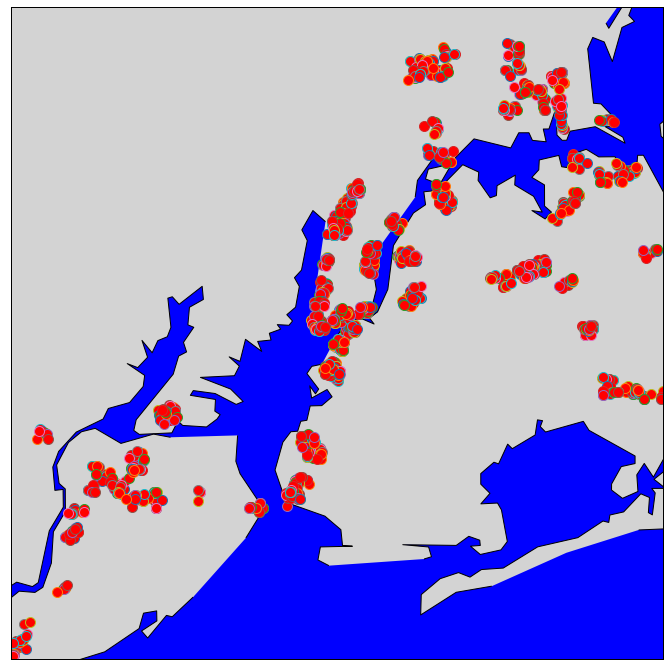

In [223]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='gnom', lat_0=40.7, lon_0=-74,
                width=40000, height=40000, resolution="h")

for index,row in nyc_venues.iterrows():
    x, y = m(row["Venue Longitude"], row['Venue Latitude'])
    plt.plot(x, y,markerfacecolor =([1,0,0]),  marker='o', markersize= 10, alpha = 1)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.drawmapboundary(fill_color='blue')
m.fillcontinents(color='lightgray',lake_color='aqua')
plt.show()

In [224]:
print(nyc_venues.shape)
print(df_traffic.shape)
print(df_linkinfo.shape)

(2087, 5)
(284794, 7)
(154, 16)


There are 2087 Venues
There are 284794 speed measurements on road segments
There are 154 road segments

Enough data to try some analysis and to try to answer our initial questions:
  What kind of businesses are located near places that have good or fast traffic throughput?
  What kind of businesses are located near places that have poor traffic throughput?
  
But first we need a measure to identify good traffic throughput and poor traffic throughput.

In [225]:
df_traffic.groupby(['LINK_ID']).describe().head()

SPEED                                                           \
          count       mean        std    min    25%    50%    75%    max   
LINK_ID                                                                    
4329472  2007.0  28.670752   9.670217   5.59  22.36  32.93  36.03  44.11   
4329473  1472.0  32.623186   9.031179   6.21  31.68  35.41  38.52  47.22   
4329483  2228.0  51.333829   3.388576  14.29  49.70  52.19  53.43  59.03   
4329507  2103.0  32.461032   7.531200   4.97  28.58  33.55  37.90  45.98   
4329508  1447.0  26.240055  13.478658   1.86  12.42  32.93  37.28  42.87   

        TRAVEL_TIME              ... STATUS         Time                       \
              count        mean  ...    75%  max   count       mean       std   
LINK_ID                          ...                                            
4329472      2007.0  237.838067  ...    0.0  0.0  2007.0  12.170404  6.589280   
4329473      1472.0  195.851223  ...    0.0  0.0  1472.0  10.207201  5.875771   
4329483      2228.0  150.390485  ...    0.0  0.0  2228.0  11.577199  6.786954   
4329507      2103.0  166.020447  ...    0.0  0.0  2103.0  11.816453  6.647906   
4329508      1447.0  402.417415  ...    0.0  0.0  1447.0  13.928127  6.296529   

                                     
         min  25%   50%   75%   max  
LINK_ID                              
4329472  0.0  7.0  12.0  18.0  23.0  
4329473  0.0  6.0  10.0  14.0  23.0  
4329483  0.0  6.0  12.0  17.0  23.0  
4329507  0.0  6.0  12.0  18.0  23.0  
4329508  0.0  9.0  15.0  19.0  23.0  

[5 rows x 32 columns]

from df_traffic.describe() we can identify the mean and std speed for each road segment. Let´s say that everything above that a speed measurement above the 75% mark is "good", anything between 25% and 75% is "bad", and anything lower than 25% is "terrible".

We start off by setting variables that can control filters

In [226]:
# These variable are used to determine the baseline

#datefilter = "01/06/2020"
timestart = 0
timeend = 24

# If you want to set the baseline over the entire set we do not need to filter on the date.
# analysis = df_traffic[df_traffic["Date"].eq(datefilter)]

baseline = df_traffic[df_traffic["Time"]<(timeend)]
baseline = df_traffic[df_traffic["Time"]>=(timestart)]

In [227]:
def add_quantile(grp):
    grp['max'] = grp['SPEED'].quantile(1)
    grp['75'] = grp['SPEED'].quantile(.75)
    grp['50'] = grp['SPEED'].quantile(.5)
    grp['25'] = grp['SPEED'].quantile(.25)
    grp['min'] = grp['SPEED'].quantile(0)
    grp['mean'] = grp['SPEED'].mean()
    grp['std'] = grp['SPEED'].std()
    return grp

# The baseline contains the required quantiles based on the average speed for 
#baseline = baseline.groupby(['LINK_ID']).apply(add_quantile(baseline))
baseline = baseline.groupby('LINK_ID').apply(add_quantile)    

In [228]:
baseline = baseline.drop(["SPEED", "TRAVEL_TIME", "STATUS", "Date", "Time", "AMPM"], axis=1)
baseline = baseline.drop_duplicates()

Analysis is performed on a single day. Change the variable datefilter to set the date to visualize on the map

In [229]:
datefilter = "01/08/2020"
analysis = df_traffic[df_traffic["Date"].eq(datefilter)]
analysis = analysis.groupby(['LINK_ID']).mean()

In [230]:
# the analysis dataframe is the merged information about the traffic speeds 
# and the road segments AND the baseline speeds for these road segments
analysis = pd.merge(analysis, baseline, on='LINK_ID', how='inner')
analysis = pd.merge(analysis, df_linkinfo, on='LINK_ID', how='inner')

In [231]:
# Let´s assign labels to the analysis dataframe based on the traffic speed as of the time of the measurement
# and the baseline traffic speed for the road segments. the baseline values have already been merged into analysis
analysis['relative_speed'] = \
    np.where(analysis['SPEED'] > analysis['max']*.75, "good", \
    np.where(analysis['SPEED'] > analysis['75'], "good", \
    np.where(analysis['SPEED'] > 35, "ok", \
    np.where(analysis['SPEED'] > analysis['50'], "ok","bad"))))

Now we visualize how the traffic on the vchosen day is better or worse than the baseline according to our own defined logic

In [232]:
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=12)
for x in range(0,len(analysis)):
    length = min(analysis["ENCODED_POLY_LINE_LVLS"][x],11)
    if (analysis["relative_speed"][x] == "good"):
        folium.PolyLine(analysis["allpoints"][x][0:length], color="green", weight=3.5, opacity=0.7).add_to(map_nyc)
    elif (analysis["relative_speed"][x] == "ok"):
        folium.PolyLine(analysis["allpoints"][x][0:length], color="orange", weight=3.5, opacity=0.7).add_to(map_nyc)
    else:
        folium.PolyLine(analysis["allpoints"][x][0:length], color="red", weight=3.5, opacity=0.7).add_to(map_nyc)

map_nyc

## Analysis phase
(3) Determine what kind of businesses are located near places that have good or fast traffic throughput and
(4) Determine what the kinds of businesses are that have poor traffic throughput nearby.

In [233]:
baseline['relative_speed'] = \
    np.where(baseline['50'] > 50, "high", \
    np.where(baseline['50'] > 25, "medium", "low"))

In [234]:
analysis = pd.merge(baseline, df_linkinfo, on='LINK_ID', how='inner')

The KNN classifier is trained against a subset of the features (road segments), and then evaluated against a training set

In [235]:
import scipy.optimize as opt
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

X = pd.DataFrame(columns=['Latitude', 'Longitude'])
Z = pd.DataFrame(columns=['LINK_ID', 'relative_speed'])

# this code is rather clunky - I did not find a better way to do this
for i in range(11,23):
    X = X.append(pd.DataFrame(analysis.iloc[:,i].values.tolist(),columns=['Latitude', 'Longitude']))
    Z = Z.append(analysis[["LINK_ID","relative_speed"]])
    
X = pd.concat([X, Z], axis=1, sort=False)
X.dropna(inplace=True)
y = X["relative_speed"]  

features=X[["Latitude","Longitude"]]
X = preprocessing.StandardScaler().fit(features).transform(features)
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2)

Lets identify the most suitable K number for the classifier on which we can use the entire training set

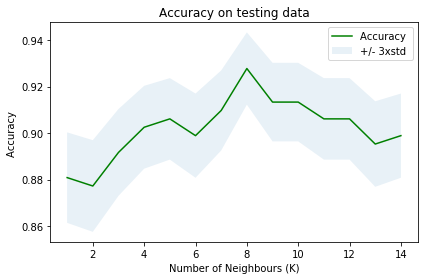

In [236]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];

#First to identify the most appropriate K num
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train_X,train_y)
    yhat=neigh.predict(test_X)
    mean_acc[n-1] = metrics.accuracy_score(test_y, yhat)
    std_acc[n-1]=np.std(yhat==test_y)/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.title('Accuracy on testing data')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

Let´s take N = 5 for the KNN classifier

In [237]:
neigh = KNeighborsClassifier(n_neighbors = 5).fit(X,y)

now let´s classify the NYC venues locations according to the KNN model to assign a baseline traffic speed most relevant to that location

In [238]:
venues_features = nyc_venues[["Venue Latitude", "Venue Longitude"]]
X = preprocessing.StandardScaler().fit(venues_features).transform(venues_features)
nyc_venues["speed"]=neigh.predict(X)

In [239]:
nyc_venues.tail()

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,speed
4025,Staten Island,Casale's Bakery & Cafe,40.521861,-74.235553,Bakery,high
4026,Staten Island,Mancini Giuffre Salon & Spa,40.522089,-74.234866,Spa,high
4027,Staten Island,Loon Chuan,40.522212,-74.234560,Chinese Restaurant,high
4028,Staten Island,Elegant Corner,40.522035,-74.234816,Women's Store,high
4029,Staten Island,Casale Bakery,40.521845,-74.235201,Bakery,high


In [240]:
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=12)
for x in range(0,len(analysis)):
    length = min(analysis["ENCODED_POLY_LINE_LVLS"][x],11)
    if (analysis["relative_speed"][x] == "high"):
        folium.PolyLine(analysis["allpoints"][x][0:length], color="green", weight=3.5, opacity=0.7).add_to(map_nyc)
    elif (analysis["relative_speed"][x] == "medium"):
        folium.PolyLine(analysis["allpoints"][x][0:length], color="orange", weight=3.5, opacity=0.7).add_to(map_nyc)
    else:
        folium.PolyLine(analysis["allpoints"][x][0:length], color="red", weight=3.5, opacity=0.7).add_to(map_nyc)
        
for index, row in nyc_venues.iterrows():
    folium.Marker([row["Venue Latitude"], row["Venue Longitude"]], icon=folium.Icon(color='blue',icon='info-sign')).add_to(map_nyc)

map_nyc

In [241]:
nyc_venues.drop(columns=["Borough", "Venue", "Venue Latitude", "Venue Longitude"], inplace=True)

In [242]:
nyc_venues.describe()

,Venue Category,speed
count,2087,2087
unique,293,3
top,Park,medium
freq,91,971


In [243]:
onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
onehot['speed'] = nyc_venues['speed'] 
nyc_venues_grouped = onehot.groupby('speed').mean().reset_index()

The intention now is to find the frequencies of these types of businesses in each category

In [244]:
nyc_venues_grouped.head()

,speed,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,high,0.000,0.001397,0.015363,0.0000,0.00000,0.001397,0.00000,0.000000,0.001397,...,0.00419,0.002793,0.001397,0.001397,0.000000,0.006983,0.005587,0.002793,0.00000,0.00000
1,low,0.005,0.000000,0.015000,0.0025,0.00000,0.000000,0.00000,0.000000,0.002500,...,0.00250,0.000000,0.000000,0.000000,0.027500,0.000000,0.000000,0.005000,0.00000,0.00000
2,medium,0.000,0.000000,0.015448,0.0000,0.00103,0.000000,0.00206,0.010299,0.001030,...,0.00103,0.002060,0.001030,0.004119,0.015448,0.000000,0.001030,0.006179,0.00309,0.00103


Venues that are likely to be near high speed areas are: Donut Shops, Pizza Place, Parks, Hotels, and other fast food type shops

Venues that are likely to be near medium speed areas are: Parks and a variety of types of bars and restaurants

Venues that are likely to be near low speed areas are: Cafe, Bakeries and bars

There is particularly little overlap between high and low speed areas

In [245]:
num_top_venues = 10
for i in nyc_venues_grouped['speed']:
    table = nyc_venues_grouped[nyc_venues_grouped['speed'] == i].T.reset_index()
    table.columns = ['venue','frequency']
    table = table.iloc[1:]
    table['frequency'] = table["frequency"].astype(float).round(3)
    print("\n", i, "speed \n", table.sort_values('frequency', ascending=False).reset_index(drop=True).head(num_top_venues))


 high speed 
                   venue  frequency
0           Pizza Place      0.045
1            Donut Shop      0.041
2                  Park      0.038
3                 Hotel      0.034
4    Chinese Restaurant      0.027
5        Sandwich Place      0.024
6  Fast Food Restaurant      0.022
7              Bus Stop      0.020
8    Italian Restaurant      0.018
9          Intersection      0.017

 low speed 
                 venue  frequency
0  Italian Restaurant      0.045
1                Park      0.042
2                 Bar      0.042
3         Coffee Shop      0.032
4           Wine Shop      0.028
5         Pizza Place      0.025
6                Café      0.022
7              Bakery      0.022
8        Cocktail Bar      0.022
9             Dog Run      0.020

 medium speed 
                   venue  frequency
0                  Park      0.048
1           Pizza Place      0.036
2           Coffee Shop      0.025
3         Deli / Bodega      0.025
4    Italian Restaurant      0.